<h1>Persian News Classification </h1> 
<h4>Multi-Label Classification Project</h4>

## Objectives

-   Loading Data and Categorizing Documents
-   Display Dataset Information
-   Text Preprocessing 
-   Identify Category-specific Keywords with TF-IDF Vectorization
-   Preprocessing and Feature Extraction for Machine Learning Models
-   Training and Evaluating Machine Learning Models for Multi-Label Text Classification
-   Evaluation and Visualization for Multi-Label Classification Performance

## Import Libraries and Set Root Directory

In [1]:
# Importing necessary libraries
import os
import random
import numpy as np
import hazm
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

# Setting the root directory for the dataset
root_directory = "./news_dataset"

## 1. Loading Data and Categorizing Documents

In [4]:
# Initialize data structures for organizing documents
docs_by_category = {}
untitled_folder_count = 0
all_files_count = 0
unique_docs = {}

# Walk through the directory structure
for root, dirs, files in os.walk(root_directory):
    # Skip processing for any 'Untitled Folder'
    if "Untitled Folder" in os.path.basename(root):
        untitled_folder_count += 1
        continue

    # Filter relevant path components
    path_components = [component for component in os.path.relpath(root, root_directory).split(os.sep) if
                       component not in ["Untitled Folder", "Root", "."]]

    # Initialize category entries in docs_by_category
    for component in path_components:
        docs_by_category.setdefault(component, {'titles': [], 'bodies': [], 'name': set()})

    # Process each file in the directory
    for file in sorted(files, key=lambda x: int(os.path.splitext(x)[0])):
        all_files_count += 1  # Track the total number of processed files
        file_path = os.path.join(root, file)  # Construct full file path
        with open(file_path, 'r', encoding='utf-8') as f:  # Open and read the file
            lines = f.readlines()
            title, body = lines[0].strip(), ''.join(lines[1:]).strip()

        # Determine categories based on path components
        file_categories = set(path_components)
        full_text = title + " " + body  # Combine title and body

        # Populate unique_docs with processed text and categories
        if file not in unique_docs:
            unique_docs[file] = {'text': full_text, 'categories': file_categories}
        else:
            unique_docs[file]['categories'].update(file_categories)

        # Update docs_by_category with file info, ensuring no duplicates
        for category in file_categories:
            if file not in docs_by_category[category]['name']:
                docs_by_category[category]['name'].add(file)
                docs_by_category[category]['titles'].append(title)
                docs_by_category[category]['bodies'].append(body)

##  2. Display Dataset Information
- Gather and present basic statistics about the dataset, such as the number of documents, unique documents, and categories.

In [3]:
# Extract texts and categories from the unique_docs dictionary
texts = [doc['text'] for doc in unique_docs.values()]
all_categories = [cat for doc in unique_docs.values() for cat in doc['categories']]
# Calculate document statistics
average_doc_length_words = np.mean([len(text.split()) for text in texts])
average_doc_length_chars = np.mean([len(text) for text in texts])
doc_lengths_words = [len(text.split()) for text in texts]
max_doc_length_words = max(doc_lengths_words)
min_doc_length_words = min(doc_lengths_words)

# Count categories and identify most common and rare categories
category_counts = pd.Series(all_categories).value_counts()
most_common_categories = category_counts.head(3).to_dict()
most_rare_categories = category_counts.tail(2).to_dict()

# Create a DataFrame to display dataset insights
dataset_info_df= pd.DataFrame({
    "Dataset Insights": [
        "Number of categories",  
        "Number of documents",  
        "Number of unique documents",  
        "Average document length (words)",  
        "Average document length (characters)",  
        "Maximum document length (words)",  
        "Minimum document length (words)", 
        "Most common categories", 
        "Most rare categories",
    ],
    "Details": [
        len(docs_by_category), 
        all_files_count,  
        len(unique_docs),
        f"{average_doc_length_words:.2f} words",  
        f"{average_doc_length_chars:.2f} characters",  
        f"{max_doc_length_words} words", 
        f"{min_doc_length_words} words",  # 
        ', '.join([f"{cat} ({count} docs)" for cat, count in most_common_categories.items()]),  
        ', '.join([f"{cat} ({count} docs)" for cat, count in most_rare_categories.items()])  
       
    ]
})
# Display the DataFrame with enhanced formatting
pd.options.display.max_colwidth = None  # Ensures text is fully visible
display(dataset_info_df.style.hide_index().set_properties(**{'text-align': 'left', 'font-size': '14pt'}))

C:\Users\asus\AppData\Local\Temp\ipykernel_22032\2541814726.py:44: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(dataset_info_df.style.hide_index().set_properties(**{'text-align': 'left', 'font-size': '14pt'}))


Dataset Insights,Details
Number of categories,113
Number of documents,17599
Number of unique documents,6539
Average document length (words),476.22 words
Average document length (characters),2431.84 characters
Maximum document length (words),11839 words
Minimum document length (words),29 words
Most common categories,"سیاسی (5325 docs), اطلاعاتی (5058 docs), امنیتی (2649 docs)"
Most rare categories,"ارتباط عوامل خارجی با گروههای برانداز سیاسی (39 docs), رزمایش مشترک (39 docs)"


## Displaying a Document Body for Each Category

In [4]:
data_samples = []
# Iterate over each category in the docs_by_category dictionary
for category, contents in docs_by_category.items():
    if contents['bodies']:
        random_index = random.randint(0, len(contents['bodies']) - 1)
        # Retrieve the title and body of the randomly selected document
        title, body = contents['titles'][random_index], contents['bodies'][random_index]
        # Truncate the body to 80 characters for display if it's longer than 90 characters
        displayed_body = (body[:87] + '...') if len(body) > 90 else body
        # Append the title, category, and truncated body to the data samples list
        data_samples.append({"Title": title, "Class": category, "Body": displayed_body})

# Convert the list of data samples into a DataFrame 
df_samples = pd.DataFrame(data_samples)

# Adjust display settings for the DataFrame
pd.options.display.max_colwidth = None  # Ensures text is fully visible
display(df_samples.style.hide_index().set_properties(**{'text-align': 'left', 'font-size': '10pt'}))


C:\Users\asus\AppData\Local\Temp\ipykernel_22032\2101258696.py:18: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(df_samples.style.hide_index().set_properties(**{'text-align': 'left', 'font-size': '10pt'}))


Title,Class,Body
اتحاديه عرب ورود حزب الله به درگيري هاي سوريه را محكوم كرد,اجتماعی,دبيركل اتحاديه عرب نسبت به آنچه از آن به عنوان دخالت حزب الله لبنان در جنك سوريه نام ...
راشاتودي :اسراييل درحمله به سوريه از سلاح اتمي استفاده كرد,اطلاعاتی,"یك مقام ارشد نظامي سوريه به شبكه خبري روسي ""راشاتودي "" گفت كه رژيم صهيونيستي در حمل..."
وزير خارجه كانادا: از تغييرطلبي مردم ايران حمايت مي كنيم,جو فرهنگی حاکم بر کشور,"تهران - ""جان برد"" وزير خارجه كانادا در نامه اي سرگشاده خطاب به ايراني ها- از آراي مردم..."
ژنرال صهيونيست : نصرالله از احتمال ويراني لبنان در صورت حمله به آن آگاه است,فرهنگی امنیتی,"سرلشكر "" يائير گولان "" فرمانده منطقه شمالي ارتش رژيم صهيونيستي گفت "" سيد حسن نصرالله ""..."
محاصره تروريست‌هاي داعش در «تلعفر»,تهدیدات اجتماعی و فرهنگی,تروريست‌هاي داعش در منطقه «القلعه» در «تلعفر» در حلقه محاصره نيروهاي امنيتي عراق قرار گ...
یکی از موفق ترین رهبران اتحادیه های کارگری انگلیس درگذشت,حرکت های سیاسی و صنفی جهت دار,لندن - ایرنا - ˈباب کراوˈ یکی از موفق ترین رهبران اتحادیه های صنفی و کارگری انگلیس که ط...
ادعاي تحليلگر آمريكايي : ايران بايد به آزادي مذهبي احترام بگذارد,سازمان ها و بنیاد های اجتماعی بحران ساز,"-""داك باندو"" تحليلگر آمريكايي مسائل سياست خارجي و حقوق مدني مدعي شد ايران بايد با حفظ ..."
دیدار مسعود بارزانی و ایاد علاوی پیرامون آخرین تحولات عراق,بحران های اجتماعی,رئیس اقلیم کردستان عراق در دیدار با رهبر ائتلاف الوطنیه ضمن بررسی آخرین تحولات سیاسی و ...
بي بي سي :آمريكا ايران را به نقض آزادي اقليت هاي مذهبي متهم كرد,فعالیت های تخریبی رسانه ها و وسایل ارتباط جمعی دشمن,تهران -تارنماي فارسي بي سي سي روز سه شنبه نوشت : گزارش سالانه وزارت امور خارجه آمريكا ...
بحران عراق وارد هفته سوم شد تکذیب مصونیت قضایی 300 نظامی اعزامی آمریکا به عراق,نظامی,بحران عراق وارد هفته سوم شد اما درگیری‌ها همچنان روند صعودی دارد و آمریکا با آنکه با زب...


## 3. Text Preprocessing
- Initializes text processing tools and defines a function to preprocess text by normalizing, tokenizing, removing stopwords and punctuation, and lemmatizing.

In [3]:
# Initialize the normalizer and lemmatizer from Hazm library
normalizer = hazm.Normalizer()
lemmatizer = hazm.Lemmatizer()

# Define a list of Persian punctuation marks to be removed and a string containing Persian numbers for identification
punctuations = [')', '(', '>', '<', "؛", "،", '{', '}', "؟", ':', "–", '»', '"', '«', '[', ']', '"', '+', '=', '?', '/',
                '//', '\\', '|', '!', '%', '&', '*', '$', '#', '؟', '*', '.', '_', '']
persian_numbers = '۰۱۲۳۴۵۶۷۸۹'
# Fetch a list of stopwords from the Hazm library
stopwords_list = hazm.stopwords_list()

# Define a function to preprocess a document's text
def preprocess_doc(doc_text):
    # Normalize the text to unify characters
    normalized_text = normalizer.normalize(doc_text)
    
    # Tokenize the normalized text
    tokens = hazm.word_tokenize(normalized_text)
    
    lemmatized_text = ""
    
    # Iterate over each token
    for token in tokens:
        # Skip tokens that are stopwords, punctuation, digits, Persian numbers, or contain English letters
        if token in stopwords_list or token in punctuations or token.isdigit() \
           or any(char in persian_numbers for char in token) or any(char in string.ascii_letters for char in token):
            continue
        
        # Lemmatize the token and retrieve the lemma part if it's a compound
        lemmatized_token = lemmatizer.lemmatize(token)
        lemma = lemmatized_token.split('#')[1] if '#' in lemmatized_token else lemmatized_token
        
        # Append the lemma to the lemmatized text string, followed by a space
        lemmatized_text += lemma + " "
    
    # Return the fully processed text, stripped of any trailing whitespace
    return lemmatized_text.strip()


## 4. Identify Category-specific Keywords with TF-IDF Vectorization
- Utilize Term Frequency-Inverse Document Frequency (TF-IDF) to extract and highlight significant keywords for each category within the dataset.

In [ ]:
# Lists to hold preprocessed texts for each category and the corresponding category labels
preprocessed_category_docs = []
category_docs = []

# Loop through each category and its documents
for category, contents in docs_by_category.items():
    # Preprocess each document in the category, join them into a single string
    category_text = " ".join([preprocess_doc(doc) for doc in contents['bodies']])
    # Append the combined preprocessed text of the category to the list
    preprocessed_category_docs.append(category_text)
    # Track the category of the processed documents
    category_docs.append(category)  

# Initialize TF-IDF vectorizer with specific parameters for category documents
tfidf_category_vectorizer = TfidfVectorizer(
    max_features=10000,  # Limit the number of features to the top 10,000 terms by term frequency across the corpus
    ngram_range=(1,3),   # Consider unigrams, bigrams, and trigrams 
    sublinear_tf=True    # Apply sublinear term frequency scaling, i.e., 1 + log(tf), to reduce the impact of high term frequency
)
# Transform the preprocessed category documents into TF-IDF matrix
tfidf_categories_matrix = tfidf_category_vectorizer.fit_transform(preprocessed_category_docs)
# Convert the TF-IDF matrix to a DataFrame for easier analysis and manipulation
df_category_tfidf = pd.DataFrame(tfidf_categories_matrix.toarray(), columns=tfidf_category_vectorizer.get_feature_names_out())


## Display Category-specific Keywords

In [ ]:
# Configure pandas display options to show full text without truncation
pd.set_option('display.max_colwidth', None)
keywords_samples = []
# Iterate over each category to identify and collect its top TF-IDF keywords
for index, category in enumerate(category_docs):
    value = df_category_tfidf.iloc[index, :]
    top_scores = value.sort_values(ascending=False).head(15)
    top_words = top_scores.index
    top_words_str = ', '.join(top_words)
    keywords_samples.append({"Class": category, "Key words": top_words_str})

# Convert the list of top keywords per category into a DataFrame
df_keyword_samples = pd.DataFrame(keywords_samples)
# Ensure that the DataFrame displays text fully without truncation
pd.options.display.max_colwidth = None
# Display the DataFrame with enhanced styling for readability
display(df_keyword_samples.style.hide_index().set_properties(**{'text-align': 'left', 'font-size': '10pt'}))

## ِDisplaying Words with Lowest IDF Scores

In [12]:
# Extract feature names and their corresponding IDF scores from the TF-IDF Vectorizer
feature_names = tfidf_category_vectorizer.get_feature_names_out()
idf_scores = tfidf_category_vectorizer.idf_
# Combine feature names with their IDF scores and sort them by IDF score
sorted_features_by_idf = sorted(zip(feature_names, idf_scores), key=lambda x: x[1])
top_n = 100
# Initialize a dictionary to hold words grouped by their IDF score
lowest_idf_words = sorted_features_by_idf[:top_n]
# Create a DataFrame to display the information
df_lowest_idf_grouped = pd.DataFrame(lowest_idf_words, columns=['Words','IDF Score'])
# Ensure long text in DataFrame cells is fully visible
pd.options.display.max_colwidth = None
# Display the DataFrame with improved formatting
display(df_lowest_idf_grouped.style.hide_index().set_properties(**{'text-align': 'left'}))


C:\Users\asus\AppData\Local\Temp\ipykernel_22032\513300708.py:14: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(df_lowest_idf_grouped.style.hide_index().set_properties(**{'text-align': 'left'}))


Words,IDF Score
آزاد,1.000000
آغاز,1.000000
آماده,1.000000
آمریکا,1.000000
آمریکایی,1.000000
آمیز,1.000000
آن,1.000000
آور,1.000000
آینده,1.000000
ابراز,1.000000


## 5. Preprocessing and Feature Extraction for Machine Learning Models
#### TF-IDF Vectorization for Multi-label Classification

In [5]:
# Initialize a list for storing preprocessed documents
preprocessed_docs = []
docs = [doc['text'] for doc in unique_docs.values()]
categories = [list(doc['categories']) for doc in unique_docs.values()]
for index, doc_text in enumerate(docs):
    preprocessed_doc = preprocess_doc(doc_text)  
    preprocessed_docs.append(preprocessed_doc) 

# Initialize a TF-IDF Vectorizer with specific parameters
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), sublinear_tf=True)
# Generate a TF-IDF matrix for the preprocessed documents
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_docs)
# Initialize the MultiLabelBinarizer for handling multilabel classification
mlb = MultiLabelBinarizer()
# Fit and transform the categories to a binary format suitable for classification
y_labels = mlb.fit_transform(categories)
# Split the dataset into training and testing sets with a 20% test size
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_matrix, y_labels, test_size=0.2, random_state=None)

#### Word2Vec Vectorization for Multi-label Classification

In [6]:
# Preprocess documents into a list of words for Word2Vec training.
preprocessed_words = [doc.split() for doc in preprocessed_docs]

# Train a Word2Vec model with adjusted hyperparameters for better embeddings.
word2vec_model = Word2Vec(sentences=preprocessed_words, 
                          vector_size=200,  # Opt for a larger vector size for more detailed word vectors.
                          window=10,        # Set a wider context window to capture more word relationships.
                          min_count=2,      # Exclude rare words appearing less than twice.
                          workers=4,        # Employ multiple worker threads for faster training.
                          epochs=10)        # Run more epochs for improved learning.

# Define a function to create a document vector by averaging its word vectors.
def document_vector(doc):
    # Filter to keep only words present in the model's vocabulary.
    doc = [word for word in doc if word in word2vec_model.wv]
    # For documents with no known words, return a zero vector.
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    # Return the mean vector for the document.
    return np.mean(word2vec_model.wv[doc], axis=0)

# Apply the document vector function to vectorize documents.
X_w2v = np.array([document_vector(doc) for doc in preprocessed_docs])

# Split the vectorized documents and labels into training and testing sets.
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_labels, test_size=0.2, random_state=None)


##  6. Training and Evaluating Machine Learning Models for Multi-Label Text Classification

### Precision and Recall Calculation for Multilabel Classification

In [7]:
def calculate_precision_recall(y_true, y_pred):
    """
    Calculate precision and recall for positive labels in a multi-label setting.
    
    Parameters:
    - y_true: numpy array, true binary indicator matrix for labels.
    - y_pred: numpy array, predicted binary indicator matrix for labels.
    
    Returns:
    - precision: The precision score for positive labels.
    - recall: The recall score for positive labels.
    """
    TP = np.sum((y_pred == 1) & (y_true == 1))
    
    FP = np.sum((y_pred == 1) & (y_true == 0))
    
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

### Training and Evaluating a Multilabel Naive Bayes Classifier

In [ ]:
def train_naive_bayes_model(X_train, y_train,X_test,y_test):
    # Initialize and train a MultiOutputClassifier with Naive Bayes
    model = MultiOutputClassifier(MultinomialNB(), n_jobs=-1)
    model.fit(X_train, y_train)  # Fit model to training data
    # Predict on test data
    nb_pred = model.predict(X_test)
    # Calculate precision and recall for the model's predictions
    precision, recall = calculate_precision_recall(y_test, nb_pred)
    return precision,recall,nb_pred
    
nb_tfidf_precision, nb_tfidf_recall,np_pred = train_naive_bayes_model(X_train_tfidf, y_train_tfidf,X_test_tfidf,y_test_tfidf)
print(f"Naive Bayes Tfidf Precision: {nb_tfidf_precision:.4f}")
print(f"Naive Bayes Tfidf Recall: {nb_tfidf_recall:.4f}")

 ### Training and Evaluating a Random Forest Classifier

In [9]:
def train_random_forest_model(X_train, y_train,X_test,y_test):
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier()
    # Compute sample weights for handling class imbalance
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    # Configure the model with specific parameters
    # `n_estimators=100`: Sets 100 trees in the forest, balancing accuracy and computational cost.
    # `max_depth=None`: Allows trees to grow deep, capturing complex patterns, with a risk of overfitting.
    # `random_state=1`: Ensures reproducible results by fixing the sequence of random splits.
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=1)
    # Train the model using the training data and sample weights
    rf_model = rf.fit(X_train, y_train, sample_weight=sample_weights)
    # Use the trained model to predict the test set
    rf_predict = rf.predict(X_test)
    # Calculate precision and recall for the Random Forest model predictions
    precision, recall = calculate_precision_recall(y_test, rf_predict)
    return precision,recall,rf_predict
rf_tfidf_precision, rf_tfidf_recall,rf_tfidf_pred = train_random_forest_model(X_train_tfidf, y_train_tfidf,X_test_tfidf,y_test_tfidf)
print(f"Random Forest Tfidf Precision: {rf_tfidf_precision:.4f}")
print(f"Random Forest Tfidf Recall: {rf_tfidf_recall:.4f}")
rf_w2v_precision, rf_w2v_recall,rf_w2v_pred = train_random_forest_model(X_train_w2v, y_train_w2v,X_test_w2v,y_test_w2v)
print(f"Random Forest w2v Precision: {rf_w2v_precision:.4f}")
print(f"Random Forest w2v Recall: {rf_w2v_recall:.4f}")

Random Forest Tfidf Precision: 0.7395
Random Forest Tfidf Recall: 0.3293
Random Forest w2v Precision: 0.4802
Random Forest w2v Recall: 0.4076


###  Multilabel Classification with Logistic Regression

In [9]:
def train_logreg_model(X_train, y_train,X_test,y_test):
    # Initialize Logistic Regression for multilabel classification using OneVsRest strategy
    logreg_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))  # Increase max_iter for convergence

    # Train the Logistic Regression model on the training dataset
    logreg_model.fit(X_train, y_train)

    # Use the trained model to make predictions on the test dataset
    logreg_pred = logreg_model.predict(X_test)

    # Calculate precision and recall for the Logistic Regression model predictions
    precision, recall = calculate_precision_recall(y_test, logreg_pred)
    return precision, recall,logreg_pred
    
logreg_tfidf_precision, logreg_tfidf_recall,logreg_tfidf_pred = train_logreg_model(X_train_tfidf, y_train_tfidf,X_test_tfidf,y_test_tfidf)
print(f"Logistic Regression Model Tfidf Precision: {logreg_tfidf_precision:.4f}")
print(f"Logistic Regression Model Tfidf Recall: {logreg_tfidf_recall:.4f}")
logreg_w2v_precision, logreg_w2v_recall,logreg_w2v_pred = train_logreg_model(X_train_w2v, y_train_w2v,X_test_w2v,y_test_w2v)
print(f"Logistic Regression Model w2v Precision: {logreg_w2v_precision:.4f}")
print(f"Logistic Regression Model w2v Recall: {logreg_w2v_recall:.4f}")

Logistic Regression Model Tfidf Precision: 0.7810
Logistic Regression Model Tfidf Recall: 0.3423
Logistic Regression Model w2v Precision: 0.7837
Logistic Regression Model w2v Recall: 0.2999


### Multilabel Classification with Support Vector Machine (SVM)

In [8]:
def train_svm_model(X_train, y_train,X_test,y_test):
    # Initialize SVM for multilabel classification using OneVsRest strategy
    svm_model = OneVsRestClassifier(LinearSVC())  # Wrap LinearSVC in OneVsRestClassifier

    # Train the SVM model on the training dataset
    svm_model.fit(X_train, y_train)

    # Use the trained model to make predictions on the test dataset
    svm_pred = svm_model.predict(X_test)

    # Calculate precision and recall for the SVM model's predictions
    precision, recall = calculate_precision_recall(y_test, svm_pred)
    return precision,recall,svm_pred
svm_tfidf_precision, svm_tfidf_recall,svm_tfidf_pred = train_svm_model(X_train_tfidf, y_train_tfidf,X_test_tfidf,y_test_tfidf)
print(f"SVM Model Tfidf Precision: {svm_tfidf_precision:.4f}")
print(f"SVM Model Tfidf Recall: {svm_tfidf_recall:.4f}")
svm_w2v_precision, svm_w2v_recall,svm_w2v_pred =train_svm_model(X_train_w2v, y_train_w2v,X_test_w2v,y_test_w2v)
print(f"SVM Model Tfidf Precision: {svm_w2v_precision:.4f}")
print(f"SVM Model Tfidf Recall: {svm_w2v_recall:.4f}")

SVM Model Tfidf Precision: 0.7262
SVM Model Tfidf Recall: 0.4102
SVM Model Tfidf Precision: 0.7745
SVM Model Tfidf Recall: 0.3047


### Multilabel Classification with Multi-Layer Perceptron (MLP)

In [22]:
def train_mlp_classifier(X_train, y_train, X_test, y_test):
    # Train an MLP classifier on the training data with an enhanced architecture
    mlp_classifier = MLPClassifier(
        hidden_layer_sizes=(100, 75, 50),  # Enhanced architecture with three layers
        activation='relu',                 # ReLU activation function
        solver='adam',                     # Adam optimizer
        alpha=0.0001,                      # L2 regularization term
        learning_rate='constant',          # Constant learning rate
        max_iter=200,                      # Maximum number of iterations
        random_state=1                    # Seed for reproducibility
    )
    mlp_classifier.fit(X_train, y_train)

    # Predict labels for the test data
    mlp_predictions = mlp_classifier.predict(X_test)
    
    # Calculate precision and recall
    precision,recall = calculate_precision_recall(y_test, mlp_predictions)
    return precision, recall,mlp_predictions

# Train and evaluate the model with TF-IDF vectors
precision_tfidf, recall_tfidf,mlp_pred_tfidf = train_mlp_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print(f"TF-IDF Precision: {precision_tfidf:.4f}")
print(f"TF-IDF Recall: {recall_tfidf:.4f}")
# Train and evaluate the model with Word2Vec vectors
precision_w2v, recall_w2v,mlp_pred_w2v = train_mlp_classifier(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
print(f"Word2Vec Precision: {precision_w2v:.4f}")
print(f"Word2Vec Recall: {recall_w2v:.4f}")


TF-IDF Precision: 0.5190
TF-IDF Recall: 0.4150
Word2Vec Precision: 0.7786
Word2Vec Recall: 0.3064


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Evaluation and Visualization for Multi-Label Classification Performance

### Label-wise Confusion Matrix Calculation and Visualization


In [11]:
# Define a function to calculate confusion matrix components for each label in multi-label classification
def calculate_label_wise_confusion_matrix(y_true, y_pred):
    """
    Calculate confusion matrix components (TP, FP, TN, FN) for each label.
    """
    n_labels = y_true.shape[1]  # Number of labels
    label_confusion_matrix = {}  # Dictionary to store confusion matrix components for each label
    
    # Calculate TP, FP, TN, FN for each label
    for i in range(n_labels):
        TP = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 1))  # True Positives
        FP = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 0))  # False Positives
        TN = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 0))  # True Negatives
        FN = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 1))  # False Negatives
        
        label_confusion_matrix[i] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}
    
    return label_confusion_matrix


def plot_confusion_matrices(label_cm, label_names):
    """
    Visualize confusion matrices
    """
    n_labels = len(label_cm)
    n_cols = 3
    n_rows = (n_labels + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()
    
    for i, (label, cm) in enumerate(label_cm.items()):
        matrix = np.array([[cm['TP'], cm['FP']], [cm['FN'], cm['TN']]])
        sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', ax=axes[i], cbar=False, square=True)
        axes[i].set_title(label_names[i], fontdict={'fontsize': 12})
        axes[i].set_xlabel('Predicted labels', fontdict={'fontsize': 10})
        axes[i].set_ylabel('True labels', fontdict={'fontsize': 10})
        axes[i].set_xticklabels(['Positive', 'Negative'], fontdict={'fontsize': 8})
        axes[i].set_yticklabels(['Positive', 'Negative'], fontdict={'fontsize': 8}, rotation=0)
        
    for j in range(i + 1, n_cols * n_rows):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


### Display Confusion Matrix for Logistic Regression model's Prediction

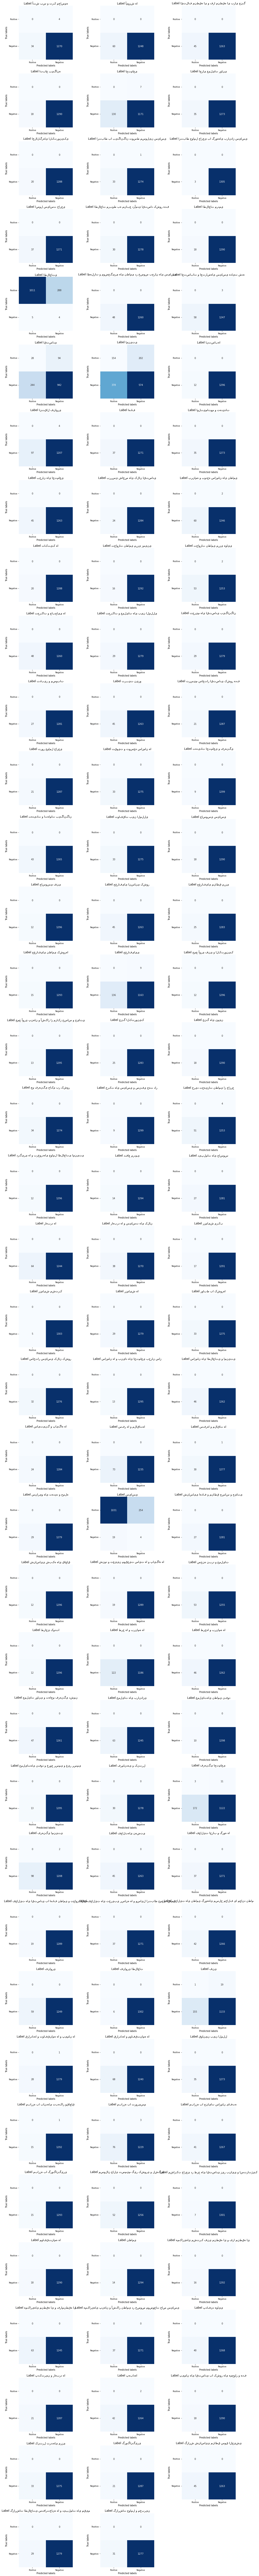

In [13]:
label_cm = calculate_label_wise_confusion_matrix(y_test_w2v, logreg_tfidf_pred)

label_names = [f'Label { mlb.classes_[i]}' for i in range(y_test_w2v.shape[1])] 
plot_confusion_matrices(label_cm, label_names)

In [12]:
def get_predicted_categories(y_pred, mlb):
    """
    For each sample prediction, returns the list of predicted categories.
    """
    predicted_categories = []
    for i in range(y_pred.shape[0]):
        # Get the categories for the current predicted sample
        categories = mlb.classes_[y_pred[i] == 1]
        predicted_categories.append(categories)
    return predicted_categories



In [17]:
predicted_categories_all = get_predicted_categories(logreg_w2v_pred, mlb)
for i, categories in enumerate(predicted_categories_all[:2]):
    print(f"Sample {i+1} Predicted Categories: {', '.join(categories)}")


Sample 1 Predicted Categories: اطلاعاتی, سیاسی
Sample 2 Predicted Categories: اطلاعاتی, سیاسی
